In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

This uses the default main branch of whr. e.g. it will use "black/white" to refer to the winner. "White" is second. 

In [7]:
data_path = '../data/cfbd/games_1869_to_2020.csv'

In [37]:
games_df = pd.read_csv(data_path)
games_df = games_df[games_df.season>2010]
games_df.shape

/home/ryan/Develop/cfb/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(8332, 25)

win_prob with 2.5 home field =  1/(1+10^(2.5/13))
win_prob with 400 elo scale =  1/(1+10^(x/400))

elo handicap for 2.5 points = 2.5/13 * 400 = 77

In [38]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")

In [74]:
scale = 16
w2 = 700
whr = whole_history_rating.Base({'scale': scale,'w2':w2, 'debug':False})

In [75]:
start_time = 0
home_team_handicap = 2.5/13*scale
verbose = False
for i,row in games_df.iterrows():
    game_time = datetime_from_cfbd(row.start_date)
    if start_time == 0: start_time = game_time
    days = (game_time-start_time).days
    home_team = row.home_team
    away_team = row.away_team
    handicap = -(1-row.neutral_site)*home_team_handicap
    mov = row.home_points-row.away_points
        
    if verbose: print("away team: {}, home team: {}".format(away_team,home_team))
    if verbose: print("winner: {} (W is home), days: {} handicap: {}".format(winner,days,handicap))
    whr.create_game(away_team,home_team,row.away_points,row.home_points, days, handicap)
    #if len(whr.games) > 100: break

In [76]:
len(whr.games)

8332

In [77]:
whr.iterate(10)

timing:

100 games: 0.21831806499903905

1000:      4.505260759000521

8332:      15.015844893998292

23179:     58.9916944889992

74781:     241.91250731699984

77239:     

In [78]:
start_perf_timer = time.perf_counter()
whr.auto_iterate(time_limit = 10, precision = 10E-3*scale/400)
end_perf_timer = time.perf_counter()
end_perf_timer-start_perf_timer

14.379029062998598

In [79]:
def get_player_history(player_name,start_time=0, seasons=[]):
    ratings = whr.ratings_for_player(player_name)
    if start_time:
        ratings = [[dt.timedelta(days=d)+start_time,elo,unc] for d,elo,unc in ratings]
    return ratings

In [83]:
players = [
           'Texas A&M',
           'Ohio State',
           'Alabama',
           'Clemson',
           #'Minnesota',
           'LSU',
           #'Vanderbilt',
           #'Florida State',
           #'Harvard',
           #'Yale',
           #'Princeton'
           #'UAB',
           #'North Dakota State',
          ]

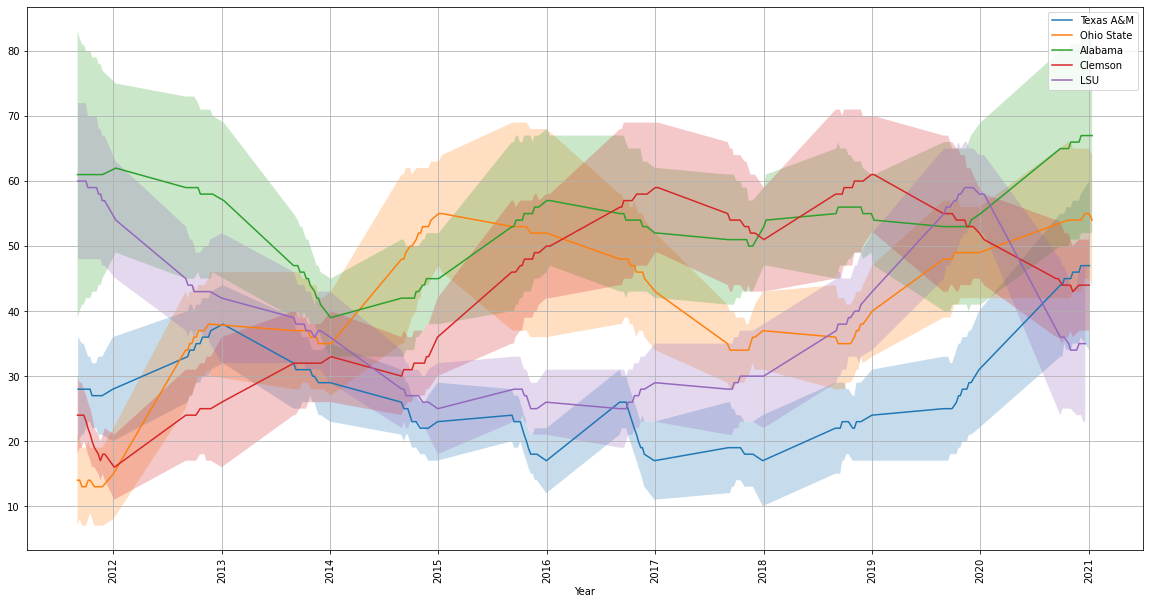

In [86]:
fig = plt.figure(figsize=[20,10])
for player in players:
    player_details = get_player_history(player,start_time=start_time)
    dates,ratings,uncertainties = list(zip(*player_details))
    ratings,uncertainties = np.asarray(ratings),np.asarray(uncertainties)
    plt.plot(dates,ratings,label=player)
    #plt.scatter(dates,ratings)
    up,down = ratings+uncertainties, ratings-uncertainties
    plt.fill_between(dates,up,down, alpha=.25)
    
    
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter('%Y')

ax = fig.axes[0]
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(years_fmt)
ax.grid(True)
#fig.autofmt_xdate()

#plt.ylim((-40,80))
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Year')
plt.savefig('scale_{}_w_{}.pdf'.format(scale,w2))


In [82]:
whr.print_ordered_ratings(current=True)

Lehigh => -219.4726118213965
Northwestern Oklahoma State => -213.06345483060298
Texas A&M-Commerce => -213.0281198877642
Drake => -212.37613100192155
Robert Morris => -211.95849856401458
San Diego => -211.3887547810383
VMI => -102.22255771489056
Morgan State => -98.87266176155603
Incarnate Word => -96.29544999605976
Houston Baptist => -95.37179218253831
Prairie View => -95.04119837803772
Cal Poly => -94.45266447080249
Sacramento State => -94.15795645685999
Abilene Christian => -93.72718960640603
Norfolk State => -92.32697209276283
Presbyterian College => -91.85443229301222
Southeastern Louisiana => -90.69759542091988
Howard => -88.42889838351614
Duquesne => -87.72349108531054
Rhode Island => -87.70665717313824
Wagner => -87.23672615107462
Texas Southern => -86.9828992475567
Central Connecticut => -85.70607179419972
Monmouth => -85.62447415368
Bucknell => -85.59419983654266
Jackson State => -85.15084103333295
Northern Colorado => -84.63252286015708
Southeast Missouri State => -84.144560